# TVE Postprocessing

In [1]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import geoplot as gplt
import geoplot.crs as gcrs
import seaborn as sns
import rasterio

from pathlib import Path
from rasterio.plot import show

sns.set_theme(style="darkgrid")

%matplotlib inline

In [2]:
epsg = "epsg:32719"
city = "vina_del_mar"
tsunami_scenario = "tsunami_1730"

In [30]:
data_path = Path(".").resolve().parent / city
output_path = data_path / "output_20220624"
postprocessing_path = output_path / "postprocessing"
postprocessing_path.mkdir(parents=True, exist_ok=True)
urban_mask = gpd.read_file(data_path / "urban" / "urban_mask.shp").to_crs(epsg)
shelters = gpd.read_file(data_path / "shelters" / "shelters_node.shp").drop(index=18)  # repeated shelter
population_areas_daytime = gpd.read_file(data_path / "population" / "daytime" / "population_areas.shp")
population_areas_nighttime = gpd.read_file(data_path / "population" / "nighttime" / "population_areas.shp")
with open(data_path / "tsunami_inundation" / tsunami_scenario / "config.json") as f:
    tsunami_config = json.load(f)
tsunami_raster = rasterio.open(data_path / "tsunami_inundation" / tsunami_scenario / "0.asc")

In [28]:
shelters.sort_values("id")

,id,x,y,evac_type,capacity,geometry
21,253418257,261152.412586,6.343420e+06,vertical,806,POINT (261152.413 6343419.983)
0,253420305,262103.206679,6.345100e+06,horizontal,1000000,POINT (262103.207 6345099.608)
4,254373577,260146.664181,6.343125e+06,horizontal,1000000,POINT (260146.664 6343124.537)
14,254380616,261441.199801,6.344413e+06,vertical,1632,POINT (261441.200 6344412.507)
19,254543886,261509.495351,6.343815e+06,vertical,1028,POINT (261509.495 6343814.624)
18,254543886,261509.495351,6.343815e+06,vertical,49,POINT (261509.495 6343814.624)
17,254548628,261767.334265,6.343893e+06,vertical,3718,POINT (261767.334 6343893.061)
16,254554396,261761.050403,6.344364e+06,vertical,35,POINT (261761.050 6344364.245)
22,255213987,260745.540612,6.343046e+06,vertical,1337,POINT (260745.541 6343046.085)
25,255217338,261169.268382,6.343111e+06,vertical,695,POINT (261169.268 6343111.138)


In [4]:
params_re = re.compile(r"\[(\w+)\]: (?:(?P<number>[0-9\.\-E]+)|(?P<text>.*))")

scenario_params = {}
for scenario_output in output_path.glob("*/*/scenario_output.txt"):
    key = scenario_output.parent.parent.name + "_" + scenario_output.parent.name
    with open(scenario_output, "r") as f:
        scenario_logs = f.read()
        params = {x: float(i) if i != "" else t for (x, i, t) in params_re.findall(scenario_logs)}
        scenario_params[key] = params

## Summary Table

In [5]:
data = (
    pd.concat(
        {
            f.stem.removeprefix(f"tve_{city}_"): pd.read_csv(f, skiprows=6)
            for f in output_path.glob("*.csv")
        }
    )
    .droplevel(1)
    .rename_axis("batch")
    .reset_index()
    .query("flow_depth_threshold == 0.5")
    .rename(
        columns={
            "[step]": "tick",
            "departure_time_mean_in_sec": "departure_time_mean",
            "count pedestrians with [moving?]": "n_moving",
            "count pedestrians with [dead?]": "n_dead",
            "count pedestrians with [evacuated?]": "n_evacuated"
        }
    )
    .assign(
        **{
        "batch_run": lambda x: x["batch"] + "_" + x["[run number]"].astype(str),
        "evacuation_type": lambda x: x["vert_evacuation_willingness_prob"].eq(0).map({True: "Horizontal", False: "Horizontal+Vertical"}),
        "seconds": lambda x: x["tick"] * tsunami_config["seconds_per_tick"],
        }
    )

    .loc[
        :,
        [
            "batch_run",
            "tick",
            "seconds",
            "evacuation_type",
            "population_scenario",
            "departure_time_mean",
            "vert_evacuation_willingness_prob",
            "n_moving",
            "n_dead",
            "n_evacuated",
        ]
    ]
)
data.head()

,batch_run,tick,seconds,evacuation_type,population_scenario,departure_time_mean,vert_evacuation_willingness_prob,n_moving,n_dead,n_evacuated
2,horizontal_dt180_20,0,0,Horizontal,daytime,180,0.0,0,0,0
3,horizontal_dt180_20,1,10,Horizontal,daytime,180,0.0,0,0,0
5,horizontal_dt180_16,0,0,Horizontal,daytime,180,0.0,0,0,0
6,horizontal_dt180_17,0,0,Horizontal,daytime,180,0.0,0,0,0
7,horizontal_dt180_19,0,0,Horizontal,daytime,180,0.0,0,0,0


In [6]:
data.tail()

,batch_run,tick,seconds,evacuation_type,population_scenario,departure_time_mean,vert_evacuation_willingness_prob,n_moving,n_dead,n_evacuated
129955,vertical75_dt660_18,356,3560,Horizontal+Vertical,daytime,660,0.75,434,45398,21404
129956,vertical75_dt660_18,357,3570,Horizontal+Vertical,daytime,660,0.75,424,45398,21414
129957,vertical75_dt660_18,358,3580,Horizontal+Vertical,daytime,660,0.75,415,45398,21423
129958,vertical75_dt660_18,359,3590,Horizontal+Vertical,daytime,660,0.75,407,45398,21431
129959,vertical75_dt660_18,360,3600,Horizontal+Vertical,daytime,660,0.75,397,45398,21441


In [7]:
final_status_stats = (
    data.query(f"seconds == {tsunami_config['max_seconds']}")
    .assign(
        **{
            "n_total": lambda x: x[["n_moving", "n_dead", "n_evacuated"]].sum(axis=1),
            "perc_moving": lambda x: x["n_moving"] / x["n_total"],
            "perc_dead": lambda x: x["n_dead"] / x["n_total"],
            "perc_evacuated": lambda x: x["n_evacuated"] / x["n_total"]
        }
    )
    .groupby(["evacuation_type", "vert_evacuation_willingness_prob", "population_scenario", "departure_time_mean"])
    [["n_moving", "n_dead", "n_evacuated", "perc_moving", "perc_dead", "perc_evacuated"]]
    .agg([np.mean, np.std])
)
final_status_stats.to_excel(postprocessing_path / "final_status_stats.xlsx")
final_status_stats

n_moving  \
                                                                                                 mean   
evacuation_type     vert_evacuation_willingness_prob population_scenario departure_time_mean            
Horizontal          0.00                             daytime             180                    175.2   
                                                                         480                    269.4   
                                                                         660                    382.2   
                                                     nighttime           180                    101.9   
                                                                         480                    144.0   
                                                                         660                    190.3   
Horizontal+Vertical 0.25                             daytime             180                    182.5   
                                                                         480                    276.5   
                                                                         660                    379.0   
                                                     nighttime           180                     99.7   
                                                                         480                    141.2   
                                                                         660                    203.8   
                    0.75                             daytime             180                    182.2   
                                                                         480                    269.5   
                                                                         660                    375.7   
                                                     nighttime           180                     99.7   
                                                                         480                    146.6   
                                                                         660                    192.9   

                                                                                                         \
                                                                                                    std   
evacuation_type     vert_evacuation_willingness_prob population_scenario departure_time_mean              
Horizontal          0.00                             daytime             180                  10.086294   
                                                                         480                  12.029593   
                                                                         660                  16.771669   
                                                     nighttime           180                  13.261892   
                                                                         480                  15.018507   
                                                                         660                  10.562512   
Horizontal+Vertical 0.25                             daytime             180                  12.048513   
                                                                         480                  12.176936   
                                                                         660                   9.933110   
                                                     nighttime           180                  11.776153   
                                                                         480                   8.715248   
                                                                         660                   9.330952   
                    0.75                             daytime             180                   9.886017   
                                                                         480                  13.542115   
                                                                    

## Status curve

In [8]:
pop_scenario_total_dict = {
    "daytime": population_areas_daytime["population"].sum(),
    "nighttime": population_areas_nighttime["population"].sum()
}

In [9]:
data_melted = (
    data.assign(
        n_total=lambda x: x["population_scenario"].map(pop_scenario_total_dict),
        Moving=lambda x: x["n_moving"] / x["n_total"],
        Dead=lambda x: x["n_dead"] / x["n_total"],
        Evacuated=lambda x: x["n_evacuated"] / x["n_total"],
    )
    .melt(
        id_vars=["evacuation_type", "vert_evacuation_willingness_prob", "population_scenario", "departure_time_mean", "batch_run", "seconds"],
        value_vars=["Moving", "Dead", "Evacuated"],
        var_name="Status",
        value_name="perc_pedestrians"
    )
    .rename(columns={"departure_time_mean": "Mean departure time"})
)
data_melted.head()

,evacuation_type,vert_evacuation_willingness_prob,population_scenario,Mean departure time,batch_run,seconds,Status,perc_pedestrians
0,Horizontal,0.0,daytime,180,horizontal_dt180_20,0,Moving,0.0
1,Horizontal,0.0,daytime,180,horizontal_dt180_20,10,Moving,0.0
2,Horizontal,0.0,daytime,180,horizontal_dt180_16,0,Moving,0.0
3,Horizontal,0.0,daytime,180,horizontal_dt180_17,0,Moving,0.0
4,Horizontal,0.0,daytime,180,horizontal_dt180_19,0,Moving,0.0


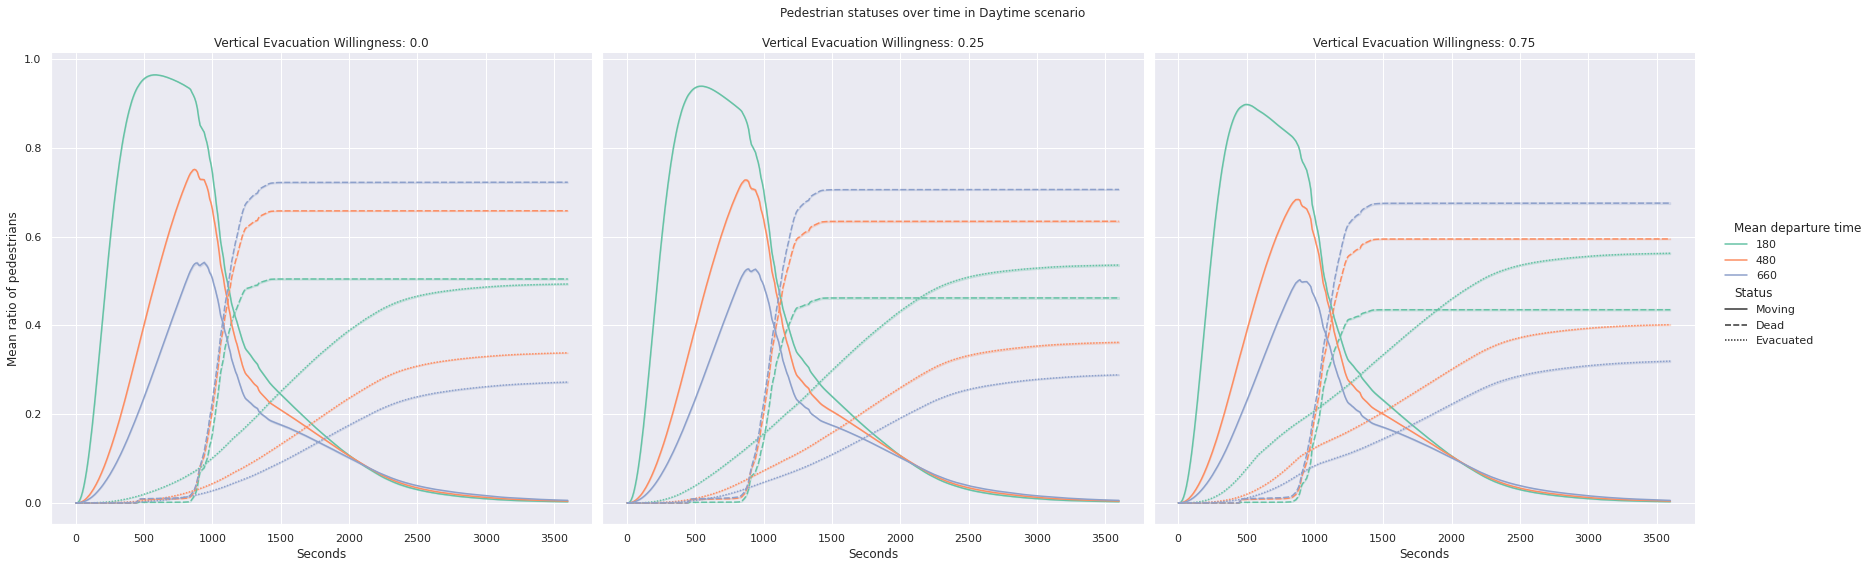

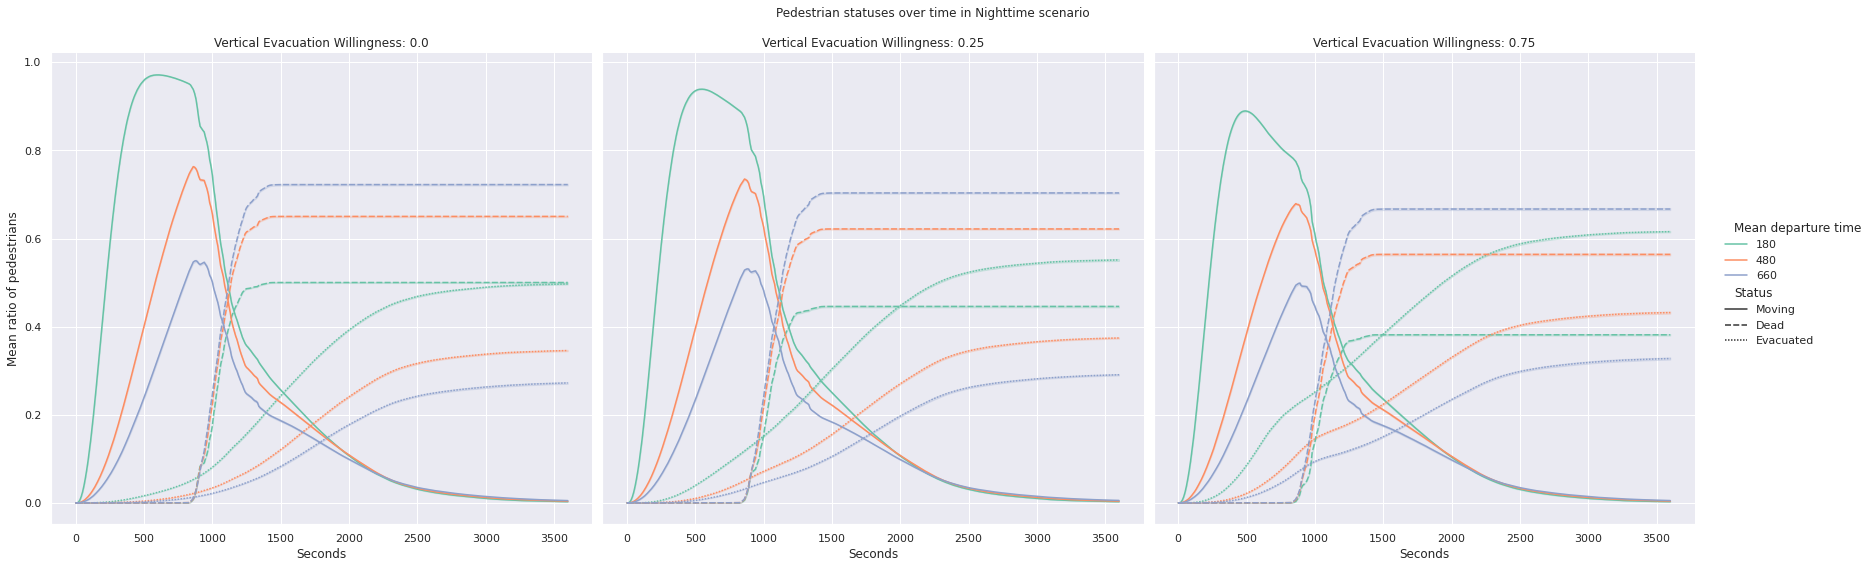

In [10]:
for pop_scenario in ["daytime", "nighttime"]:
    g = sns.relplot(
        data=data_melted.query("population_scenario == @pop_scenario"),
        x="seconds",
        y="perc_pedestrians",
        col="vert_evacuation_willingness_prob",
        hue="Mean departure time",
        style="Status",
        kind="line",
        ci="sd",
        palette="Set2",
        height=8,
    )

    (
        g.set_axis_labels("Seconds", "Mean ratio of pedestrians")
        .set_titles("Vertical Evacuation Willingness: {col_name}")
        .tight_layout(w_pad=1)
    )
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"Pedestrian statuses over time in {pop_scenario.capitalize()} scenario")
    plt.savefig(postprocessing_path / f"status_curve_{pop_scenario}.png", dpi=300)
    plt.show()

## Heatmap

In [11]:
pedestrians = (
    pd.concat(
        {
            f.parent.parent.name + "_" + f.parent.name: pd.read_csv(f)
            for f in output_path.glob("*/*/pedestrians.csv")
        }
    )
    .rename_axis(["batch_run", "index"])
    .reset_index()
    .assign(
        **{
            "params": lambda x: x["batch_run"].map(scenario_params),
            "population_scenario": lambda x: x["params"].apply(lambda row: row.get("population_scenario")),
            "vert_evacuation_willingness_prob": lambda x: x["params"].apply(lambda row: row.get("vert_evacuation_willingness_prob")),
            "evacuation_type": lambda x: x["vert_evacuation_willingness_prob"].eq(0).map({True: "Horizontal", False: "Horizontal+Vertical"}),
            "departure_time_mean": lambda x: x["params"].apply(lambda row: row.get("departure_time_mean_in_sec")),
            "flow_depth_threshold": lambda x: x["params"].apply(lambda row: row.get("flow_depth_threshold")),
        }
    )
    .query("flow_depth_threshold == 0.5")
)
pedestrians.head()

,batch_run,index,id,init_decision,decision,init_x,init_y,age,depar_time,base_speed,...,end_time,moving,evacuated,dead,params,population_scenario,vert_evacuation_willingness_prob,evacuation_type,departure_time_mean,flow_depth_threshold
134472,vina_del_mar_horizontal_dt180_11,0,54669,horizontal,horizontal,517.084241,366.922720,25,4.213029,3.144486,...,202,False,True,False,{'data_path': '/home/jleon/tsunami-vertical-ev...,daytime,0.0,Horizontal,180.0,0.5
134473,vina_del_mar_horizontal_dt180_11,1,7806,horizontal,horizontal,172.499970,259.169197,76,9.020506,1.722457,...,81,False,True,False,{'data_path': '/home/jleon/tsunami-vertical-ev...,daytime,0.0,Horizontal,180.0,0.5
134474,vina_del_mar_horizontal_dt180_11,2,58784,horizontal,horizontal,538.927906,555.824165,50,18.338101,2.804000,...,112,False,True,False,{'data_path': '/home/jleon/tsunami-vertical-ev...,daytime,0.0,Horizontal,180.0,0.5
134475,vina_del_mar_horizontal_dt180_11,3,47771,horizontal,horizontal,333.963016,298.534262,55,19.147274,2.683829,...,101,False,False,True,{'data_path': '/home/jleon/tsunami-vertical-ev...,daytime,0.0,Horizontal,180.0,0.5
134476,vina_del_mar_horizontal_dt180_11,4,45165,horizontal,horizontal,377.340414,282.204074,70,24.053138,2.143057,...,100,False,False,True,{'data_path': '/home/jleon/tsunami-vertical-ev...,daytime,0.0,Horizontal,180.0,0.5


In [19]:
x_min, x_max = 0, tsunami_raster.meta["width"] + 1
y_min, y_max = 0, tsunami_raster.meta["height"] + 1
bin_size = 5
pedestrians_death = (
    pedestrians.assign(
        **{
            "x_cell": lambda x: pd.cut(x["init_x"], bins=np.arange(x_min, x_max + 1, bin_size)),
            "y_cell": lambda x: pd.cut(x["init_y"], bins=np.arange(y_min, y_max + 1, bin_size))
        }
    )
    .groupby(
        [
            "evacuation_type",
            "vert_evacuation_willingness_prob",
            "population_scenario",
            "departure_time_mean",
            "x_cell",
            "y_cell", 
        ]
    )
    .agg(**{"death_ratio": ("dead", np.mean)})
    .reset_index()
    .groupby(
        [
            "evacuation_type",
            "vert_evacuation_willingness_prob",
            "population_scenario",
            "departure_time_mean",
        ]
    ).filter(lambda x: x["death_ratio"].notnull().any())
)
pedestrians_death.head()

,evacuation_type,vert_evacuation_willingness_prob,population_scenario,departure_time_mean,x_cell,y_cell,death_ratio
0,Horizontal,0.0,daytime,180.0,"(0, 5]","(0, 5]",NaN
1,Horizontal,0.0,daytime,180.0,"(0, 5]","(5, 10]",NaN
2,Horizontal,0.0,daytime,180.0,"(0, 5]","(10, 15]",NaN
3,Horizontal,0.0,daytime,180.0,"(0, 5]","(15, 20]",NaN
4,Horizontal,0.0,daytime,180.0,"(0, 5]","(20, 25]",NaN


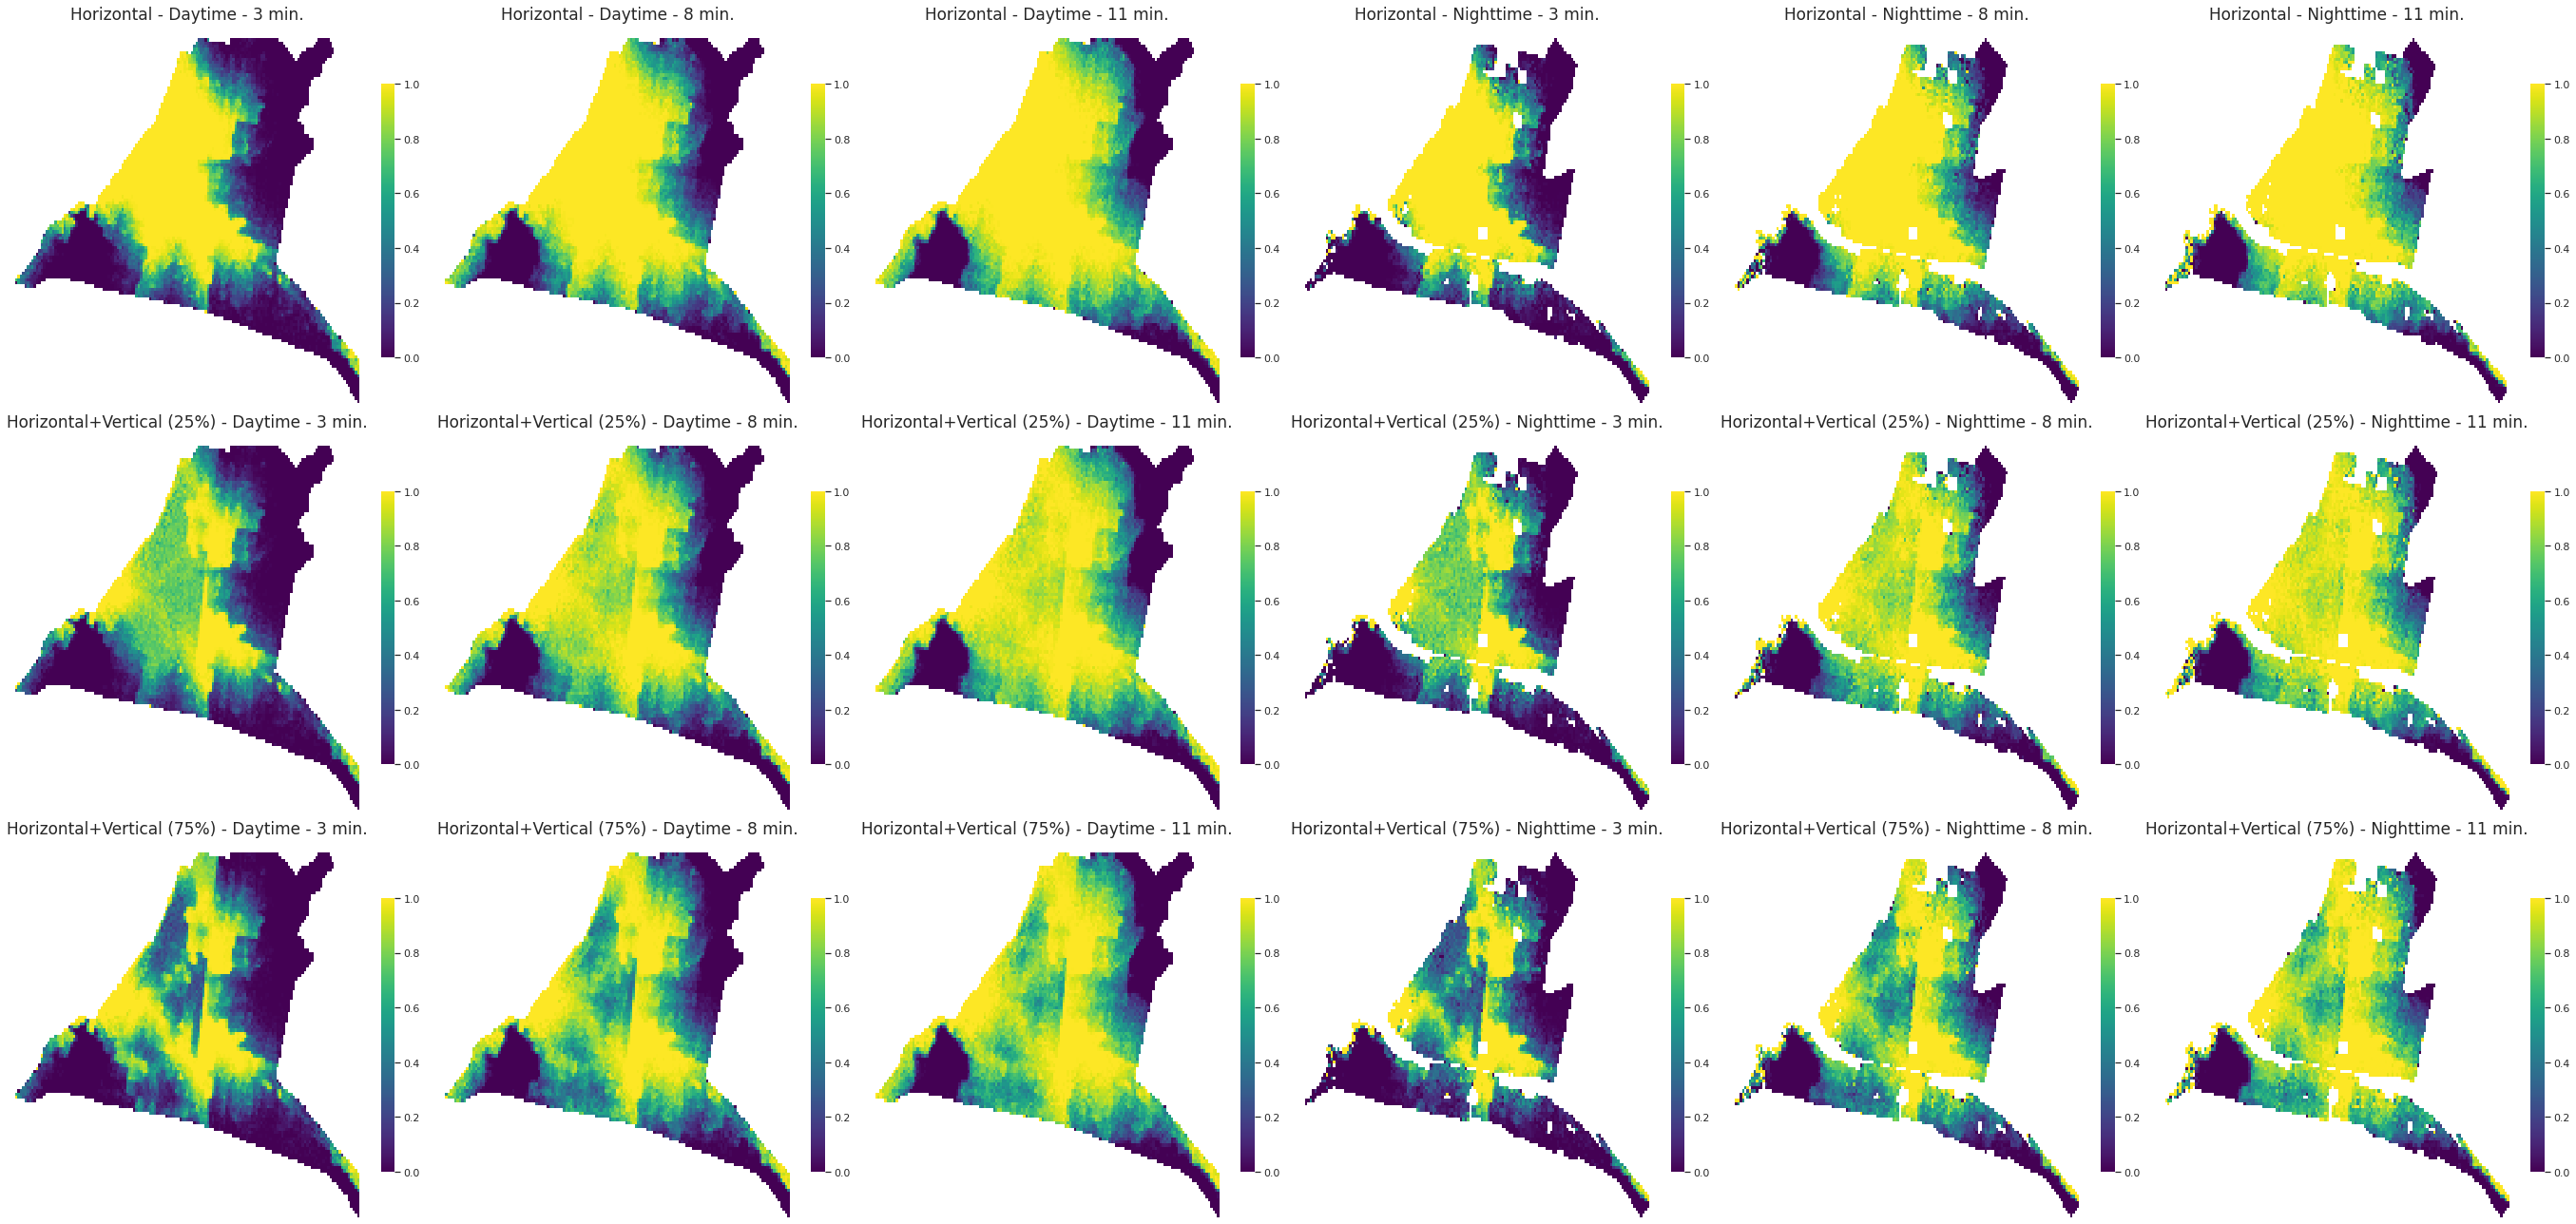

In [20]:
pedestrians_death_groups = pedestrians_death.groupby(
        [
            "evacuation_type",
            "vert_evacuation_willingness_prob",
            "population_scenario",
            "departure_time_mean",
        ]
    )

with sns.axes_style("white"):
    fig, axs = plt.subplots(3, 6, figsize=(38, 18), sharex=True, sharey=True)
    for (name, df), ax in zip(pedestrians_death_groups, axs.reshape(-1)):
        evac_type, vert_will, pop_scenario, depar_time = name
        if evac_type == 'Horizontal':
            title = f"{evac_type} - {pop_scenario.capitalize()} - {int(depar_time / 60)} min."
        else:
            title = f"{evac_type} ({vert_will:.0%}) - {pop_scenario.capitalize()} - {int(depar_time / 60)} min."
        sns.heatmap(
            df.pivot_table(
                index="y_cell",
                columns="x_cell",
                values="death_ratio",
                aggfunc=np.mean,
            ).values,
            vmin=0,
            vmax=1,
            cmap="viridis",
            xticklabels=False,
            yticklabels=False,
#             square=True,
            cbar=True,
            cbar_kws={
                "shrink": .75,
#                 "orientation": "horizontal"
            },
            ax=ax
        )
        ax.invert_yaxis()
        ax.set_title(title, fontsize=17, pad=20)
fig.subplots_adjust(hspace=.2, wspace=.1)
fig.tight_layout()
fig.savefig(postprocessing_path / "death_ratio_heatmap.png", dpi=300)
fig.show()

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(
        df.pivot_table(
            index="y_cell",
            columns="x_cell",
            values="death_ratio",
            aggfunc=np.mean,
        ).values,
        vmin=0,
        vmax=1,
        cmap="viridis",
        xticklabels=False,
        yticklabels=False
    )
    ax.invert_yaxis()
    fig.show()

## Shelters

In [31]:
shelters_evacuation = (
    pedestrians.query("evacuated == True")
    .rename(columns={"final_node": "shelter"})
    .astype({"shelter": "int"})
    .groupby(
        [
            "batch_run",
            "evacuation_type",
            "vert_evacuation_willingness_prob",
            "population_scenario",
            "departure_time_mean",
            "shelter",
        ]
    )
    .agg(n_evacuated=("id", "count"))
    .reset_index()
)

shelters_evacuation.head()

,batch_run,evacuation_type,vert_evacuation_willingness_prob,population_scenario,departure_time_mean,shelter,n_evacuated
0,vina_del_mar_horizontal_dt180_11,Horizontal,0.0,daytime,180.0,253420305,2984
1,vina_del_mar_horizontal_dt180_11,Horizontal,0.0,daytime,180.0,254373577,1073
2,vina_del_mar_horizontal_dt180_11,Horizontal,0.0,daytime,180.0,255793338,214
3,vina_del_mar_horizontal_dt180_11,Horizontal,0.0,daytime,180.0,255793686,1170
4,vina_del_mar_horizontal_dt180_11,Horizontal,0.0,daytime,180.0,255794025,2452


In [32]:
shelters_evacuation_mean = (
    shelters_evacuation.groupby(
        [
            "evacuation_type",
            "vert_evacuation_willingness_prob",
            "population_scenario",
            "departure_time_mean",
            "shelter",
        ]
    )
    .agg(mean_evacuated=("n_evacuated", "mean"))
    .reset_index()
    .merge(
        shelters.rename(columns={"id": "shelter"}).drop(columns=["x", "y"]),
        how="left",
        on="shelter"
    )
    .pipe(lambda x: gpd.GeoDataFrame(x, geometry="geometry"))
)

shelters_evacuation_mean.head()

,evacuation_type,vert_evacuation_willingness_prob,population_scenario,departure_time_mean,shelter,mean_evacuated,evac_type,capacity,geometry
0,Horizontal,0.0,daytime,180.0,253420305,2958.3,horizontal,1000000,POINT (262103.207 6345099.608)
1,Horizontal,0.0,daytime,180.0,254373577,1057.0,horizontal,1000000,POINT (260146.664 6343124.537)
2,Horizontal,0.0,daytime,180.0,255793338,218.0,horizontal,1000000,POINT (260461.277 6343137.171)
3,Horizontal,0.0,daytime,180.0,255793686,1165.1,horizontal,1000000,POINT (260496.315 6343397.257)
4,Horizontal,0.0,daytime,180.0,255794025,2448.7,horizontal,1000000,POINT (260576.748 6343126.096)


In [40]:
shelters_evacuation_mean_groups = (
    shelters_evacuation_mean.groupby(
        [
            "evacuation_type",
            "vert_evacuation_willingness_prob",
            "population_scenario",
            "departure_time_mean",
        ]
    )
)
for name, df in shelters_evacuation_mean_groups:
#     print(name)
    pass

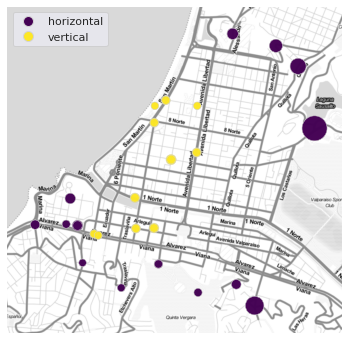

In [45]:
pop_scenario = "daytime"
evac_type = "Horizontal+Vertical"
departure_time_mean = 480
df = shelters_evacuation_mean.query(
    "population_scenario == @pop_scenario and evacuation_type == @evac_type and departure_time_mean == @departure_time_mean"
)
ax = gplt.pointplot(
    df.to_crs("epsg:4326"),
    projection=gcrs.WebMercator(),
    scale="mean_evacuated",
    limits=(7.5, 25),
    hue="evac_type",
    cmap="viridis",
    # scheme=scheme,
    legend=True,
    legend_var="hue",
    edgecolor="lightgray",
    linewidth=0.5,
    # legend_values=[8000000, 2000000, 1000000, 100000],
    # legend_labels=['8 million', '2 million', '1 million', '100 thousand'],
    # legend_kwargs={'frameon': False, 'loc': 'lower right'},
    # ax=ax
    alpha=0.85
)
gplt.webmap(
    df.to_crs("epsg:4326"),
    projection=gcrs.WebMercator(),
    provider=cx.providers.Stamen.TonerLite,
    ax=ax
)
# plt.title("Kernel density estimation of dead pedestrians", fontsize=14)
# plt.savefig(postprocessing_path / f"kde_example.png", dpi=300)
plt.show()